<a href="https://colab.research.google.com/github/faranbutt/Flower-Vision/blob/main/Flower_Vision_Resnet%F0%9F%8C%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.7 MB/s eta 0:00:00


In [74]:
import gcsfs
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
from torchvision import transforms,models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
from glob import iglob
from tqdm import tqdm
import os

In [5]:
# 1) Install system build tools (needed to compile crcmod)
!sudo apt-get update -y
!sudo apt-get install -y build-essential python3-dev

# 2) Uninstall any existing crcmod and reinstall from source (force compilation)
!pip uninstall -y crcmod
!pip install --no-binary :all: crcmod

# 3) Verify the compiled extension is present
import crcmod, importlib, sys
print("crcmod module:", crcmod.__file__)
print("Has _using_extension:", hasattr(crcmod, "_using_extension"))
print("crcmod._using_extension:", getattr(crcmod, "_using_extension", None))

!gsutil -m cp -r gs://practical-ml-vision-book-data/flowers_5_jpeg .


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,939 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe

In [7]:
!ls /content/flowers_5_jpeg/flower_photos/

all_data.csv	     flowers_200_folders.zip	   roses
daisy		     flowers_200_presplit.zip	   roses.zip
daisy.zip	     flowers_200_unlabeled.zip	   sunflowers
dandelion	     flowers_full_with_csv.zip	   sunflowers.zip
dandelion.zip	     inception_v3_2016_08_28.ckpt  train_set_cleaned.csv
dict.txt	     LICENSE.txt		   train_set.csv
eval_set.csv	     open_image_inception_v3.ckpt  tulips
flowers_200_csv.zip  README.txt			   tulips.zip


In [ ]:
def find_local_path(orig_path):

    p = str(orig_path).strip()
    filename = os.path.basename(p)
    class_name = os.path.basename(os.path.dirname(p))
    cand = os.path.join(root_dir, class_name, filename)
    if os.path.isfile(cand):
        return cand
    cand2 = os.path.join(root_dir, filename)
    if os.path.isfile(cand2):
        return cand2
    pattern = os.path.join(root_dir, "**", filename)
    for match in iglob(pattern, recursive=True):
        if os.path.isfile(match):
            return match
    cand3 = os.path.join(root_dir, p)
    if os.path.isfile(cand3):
        return cand3
    return None

In [ ]:
def clean_csv(df,csv_path,clean_csv_path):
  df = pd.read_csv(csv_path, header=None)
  df.columns = ["orig_path", "label"]
  print("Total rows in CSV:", len(df))
  found_paths = []
  bad_rows = []
  for i, row in tqdm(df.iterrows(), total=len(df)):
    orig = row["orig_path"]
    local = find_local_path(orig)
    if local is None:
      bad_rows.append((i, orig, row["label"]))
    else:
      found_paths.append((local, row["label"]))

  print(f"Valid found: {len(found_paths)}  |  Missing: {len(bad_rows)}")
  if len(bad_rows) > 0:
    print("First 10 missing examples (index, orig_path, label):")
    for t in bad_rows[:10]:
      print(t)
  clean_df = pd.DataFrame(found_paths, columns=["local_path", "label"])
  clean_df.to_csv(clean_csv_path, index=False)
  print("Saved cleaned CSV to:", clean_csv_path)

In [79]:
#train_data
csv_path = "/content/flowers_5_jpeg/flower_photos/train_set.csv"
clean_csv_path = "/content/flowers_5_jpeg/flower_photos/train_set_cleaned.csv"
clean_csv(df,csv_path,clean_csv_path)

#test_data
csv_path = "/content/flowers_5_jpeg/flower_photos/eval_set.csv"
clean_csv_path = "/content/flowers_5_jpeg/flower_photos/eval_set_cleaned.csv"
clean_csv(df,csv_path,clean_csv_path)


Total rows in CSV: 3300


100%|██████████| 3300/3300 [00:00<00:00, 18964.99it/s]


Valid found: 3299  |  Missing: 1
First 10 missing examples (index, orig_path, label):
(2552, 'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/9976515506_d496c5e72c.jpg', 'tulips')
Saved cleaned CSV to: /content/flowers_5_jpeg/flower_photos/train_set_cleaned.csv
Total rows in CSV: 370


100%|██████████| 370/370 [00:00<00:00, 15987.68it/s]

Valid found: 370  |  Missing: 0
Saved cleaned CSV to: /content/flowers_5_jpeg/flower_photos/eval_set_cleaned.csv


In [8]:
df = pd.read_csv('/content/flowers_5_jpeg/flower_photos/train_set_cleaned.csv')
df.head(2)

,local_path,label
0,/content/flowers_5_jpeg/flower_photos/daisy/75...,daisy
1,/content/flowers_5_jpeg/flower_photos/dandelio...,dandelion


In [63]:
image_height = 224
image_width = 224
csv_path = "/content/flowers_5_jpeg/flower_photos/train_set_cleaned.csv"
root_dir = "/content/flowers_5_jpeg/flower_photos"

In [10]:
transform = transforms.Compose([
   transforms.Resize((image_height,image_width)),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [11]:
class FlowersDatasetV1(Dataset):
  def __init__(self,csv_path,transform=None):
    self.data = pd.read_csv(csv_path)
    self.transform = transform
    self.classes = sorted(self.data['label'].unique())
    self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
    self.idx_to_class = {i:c for c,i in self.class_to_idx.items()}

  def __len__(self):
    return len(self.data)

  # def __getitem__(self,idx):
  #   row = self.data.iloc[idx]
  #   img_rel_path = row[0]
  #   label_str = row[1]

  #   filename = os.path.basename(img_rel_path)
  #   class_name = os.path.basename(os.path.dirname(img_rel_path))
  #   img_path = os.path.join(self.root_dir, class_name, filename)
  #   img = Image.open(img_path).convert("RGB")

  #   if self.transform:
  #     img = self.transform(img)

  #   label = self.class_to_idx[label_str]
  #   return img,label
  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    img_path = row['local_path']
    label_str = row['label']

    if not os.path.isfile(img_path):
      raise FileNotFoundError(f"File missing: {img_path} (idx={idx})")
    img = Image.open(img_path).convert("RGB")
    if self.transform:
        img = self.transform(img)
    label = self.class_to_idx[label_str]
    return img, label

In [12]:
dataset = FlowersDatasetV1(csv_path, transform=transform)
loader = DataLoader(dataset=dataset,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)

In [13]:
images, labels = next(iter(loader))
print("Batch shape:", images.shape)
print("Sample labels:", labels[:8])

Batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([4, 4, 1, 3, 2, 4, 1, 4])


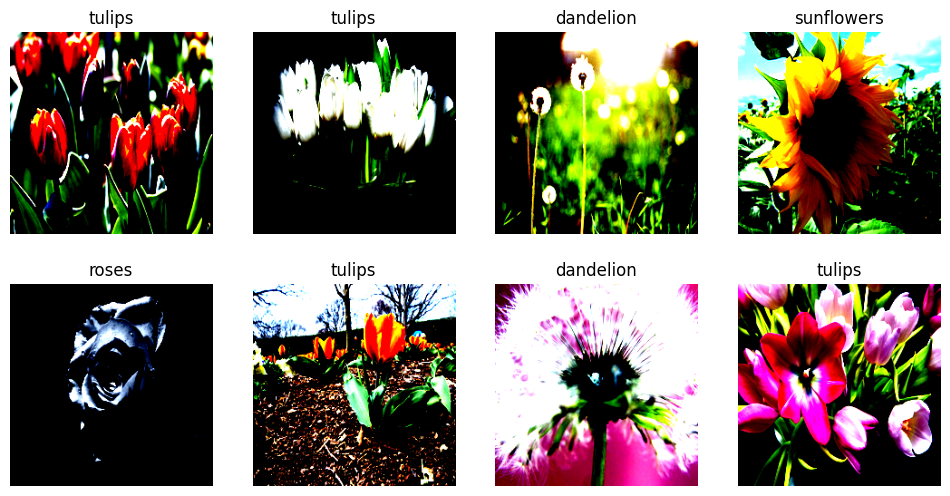

In [14]:
plt.figure(figsize=(12,6))
for i in range(8):
  plt.subplot(2,4,i+1)
  img = images[i].numpy().transpose((1,2,0))
  plt.imshow(img)
  plt.axis('off')
  plt.title(dataset.classes[labels[i].item()])
plt.show()

In [15]:
def create_model(num_classes,dropout):
  model = models.resnet18(pretrained=True)
  in_features = model.fc.in_features
  model.fc = nn.Sequential(
      nn.Dropout(dropout),
      nn.Linear(in_features,num_classes)
    )
  return model

In [30]:
def train_model(model,train_loader,val_loader,criterion,optimizer,device,n_epochs=20,patience=3):
  best_loss = float('inf')
  patience_counter = 0

  for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for images,labels in train_loader:

      images,labels = images.to(device),labels.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
      for images,labels in val_loader:
        images,labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        val_loss += loss.item()
    avg_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{n_epochs} val_loss {avg_loss}")

    if avg_loss < best_loss:
      best_loss = avg_loss
      patience_counter = 0

    else:
      patience_counter += 1
      if patience_counter > patience:
        print("Early Stopping Activated!")
        break
  return best_loss,model

In [31]:
def objective(trial):
  batch_size = trial.suggest_categorical('batch_size',[16,32,24])
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
  dropout = trial.suggest_float('dropout',0.2,0.7)
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
  transform = transforms.Compose([
    transforms.Resize((image_height,image_width )),
    transforms.ToTensor(),
    ])
  dataset = FlowersDatasetV1(csv_path,transform=transform)
  train_idx,val_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42)
  train_dataset = torch.utils.data.Subset(dataset,train_idx)
  val_dataset = torch.utils.data.Subset(dataset,val_idx)

  train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2, pin_memory=True)
  val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2, pin_memory=True)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = create_model(num_classes=len(dataset.classes),dropout=dropout)
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  if optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(),lr=lr)
  else:
    optimizer = optim.SGD(model.parameters(),lr=lr,momentum=0.9)
  val_loss,best_model = train_model(model,train_loader,val_loader,criterion,optimizer,device,n_epochs=20)
  return val_loss,best_model


In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=10)
print("Best_Trial")
trial = study.best_trial
print(trial.params)

[I 2025-08-24 13:53:36,618] A new study created in memory with name: no-name-1eae08ac-d431-4836-924a-a6e96d5514b8
/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date we

Epoch 1/20 val_loss 1.5949033328465052
Epoch 2/20 val_loss 4.088310457411266
Epoch 3/20 val_loss 52.56852790287563
Epoch 4/20 val_loss 1.2745562110628401
Epoch 5/20 val_loss 1.188454855056036
Epoch 6/20 val_loss 1.2755329325085594
Epoch 7/20 val_loss 1.5268498545601255
Epoch 8/20 val_loss 1.2140145245052518


[I 2025-08-24 13:55:36,500] Trial 0 finished with value: 1.188454855056036 and parameters: {'batch_size': 32, 'lr': 0.0076207821746750405, 'dropout': 0.5976203299694998, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.188454855056036.


Epoch 9/20 val_loss 1.3557382453055609
Early Stopping Activated!


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.4025913689817701
Epoch 2/20 val_loss 0.2784451541623899
Epoch 3/20 val_loss 0.22983151048954045
Epoch 4/20 val_loss 0.22040581024651015
Epoch 5/20 val_loss 0.20476875341098225
Epoch 6/20 val_loss 0.21464816427656583
Epoch 7/20 val_loss 0.20454390120825597
Epoch 8/20 val_loss 0.20835439641294734
Epoch 9/20 val_loss 0.20732566740896022
Epoch 10/20 val_loss 0.21555271664900438


[I 2025-08-24 13:58:05,913] Trial 1 finished with value: 0.20454390120825597 and parameters: {'batch_size': 24, 'lr': 2.5336370914481027e-05, 'dropout': 0.4695420943121008, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.20454390120825597.


Epoch 11/20 val_loss 0.21431362667187517
Early Stopping Activated!


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.7818949563162667
Epoch 2/20 val_loss 0.5040272843270075
Epoch 3/20 val_loss 0.39631951848665875
Epoch 4/20 val_loss 0.3388130828028634
Epoch 5/20 val_loss 0.30578665524011567
Epoch 6/20 val_loss 0.27333360484668184
Epoch 7/20 val_loss 0.25761844049252214
Epoch 8/20 val_loss 0.24437554712806428
Epoch 9/20 val_loss 0.2330672861564727
Epoch 10/20 val_loss 0.23467373927789076
Epoch 11/20 val_loss 0.21534797952820858
Epoch 12/20 val_loss 0.21106852826085828
Epoch 13/20 val_loss 0.2092118507162446
Epoch 14/20 val_loss 0.20423931362373487
Epoch 15/20 val_loss 0.1959526486517418
Epoch 16/20 val_loss 0.20347355759613925
Epoch 17/20 val_loss 0.19539455390934432
Epoch 18/20 val_loss 0.18588779336728511
Epoch 19/20 val_loss 0.18402799915167548


[I 2025-08-24 14:02:39,012] Trial 2 finished with value: 0.18402799915167548 and parameters: {'batch_size': 16, 'lr': 0.00012174298467674994, 'dropout': 0.6219243284509017, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.18402799915167548.


Epoch 20/20 val_loss 0.1919827428979001


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.9031941110179538
Epoch 2/20 val_loss 0.6419895780938012
Epoch 3/20 val_loss 0.5060590981017976
Epoch 4/20 val_loss 0.4324667180577914
Epoch 5/20 val_loss 0.3831085445625441
Epoch 6/20 val_loss 0.3511793365081151
Epoch 7/20 val_loss 0.34374755887048586
Epoch 8/20 val_loss 0.3053918794861862
Epoch 9/20 val_loss 0.295411233036291
Epoch 10/20 val_loss 0.28747651335738955
Epoch 11/20 val_loss 0.2711382620923576
Epoch 12/20 val_loss 0.26483969550047604
Epoch 13/20 val_loss 0.25852846380855354
Epoch 14/20 val_loss 0.2418495382049254
Epoch 15/20 val_loss 0.23502025504906973
Epoch 16/20 val_loss 0.23842829341689745
Epoch 17/20 val_loss 0.228049669946943
Epoch 18/20 val_loss 0.22533620614558458
Epoch 19/20 val_loss 0.22006446238429772


[I 2025-08-24 14:07:12,745] Trial 3 finished with value: 0.21746882884984925 and parameters: {'batch_size': 16, 'lr': 7.426983638623261e-05, 'dropout': 0.5733751622575168, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.18402799915167548.


Epoch 20/20 val_loss 0.21746882884984925


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 1.4045479808534895
Epoch 2/20 val_loss 1.1603169270924159
Epoch 3/20 val_loss 0.9828296871412368
Epoch 4/20 val_loss 0.8547876335325695
Epoch 5/20 val_loss 0.7555281718571981
Epoch 6/20 val_loss 0.6881109476089478
Epoch 7/20 val_loss 0.6222137737841833
Epoch 8/20 val_loss 0.5792686598641532
Epoch 9/20 val_loss 0.5370752059278034
Epoch 10/20 val_loss 0.5046597988832564
Epoch 11/20 val_loss 0.4787928802626474
Epoch 12/20 val_loss 0.4575780715261187
Epoch 13/20 val_loss 0.4412828570320493
Epoch 14/20 val_loss 0.421120129880451
Epoch 15/20 val_loss 0.40584087513741995
Epoch 16/20 val_loss 0.3915792150156839
Epoch 17/20 val_loss 0.37593260620321545
Epoch 18/20 val_loss 0.3627450622263409
Epoch 19/20 val_loss 0.35617445976961226


[I 2025-08-24 14:11:36,656] Trial 4 finished with value: 0.3426943910973413 and parameters: {'batch_size': 32, 'lr': 4.45009317216445e-05, 'dropout': 0.22096422839398883, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.18402799915167548.


Epoch 20/20 val_loss 0.3426943910973413


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.3536399570958955
Epoch 2/20 val_loss 0.26270072295197416
Epoch 3/20 val_loss 0.235750991762394
Epoch 4/20 val_loss 0.21825813568596328
Epoch 5/20 val_loss 0.2111734570713625
Epoch 6/20 val_loss 0.1924244417875473
Epoch 7/20 val_loss 0.18996304087340832
Epoch 8/20 val_loss 0.18807671474115478
Epoch 9/20 val_loss 0.19899539124231697
Epoch 10/20 val_loss 0.19709350427313307
Epoch 11/20 val_loss 0.1958144902074266


[I 2025-08-24 14:14:17,640] Trial 5 finished with value: 0.18807671474115478 and parameters: {'batch_size': 16, 'lr': 0.0004050990705917838, 'dropout': 0.4696643679814304, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.18402799915167548.


Epoch 12/20 val_loss 0.2124407974687139
Early Stopping Activated!


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.24299074341321275
Epoch 2/20 val_loss 0.2553937374226128
Epoch 3/20 val_loss 0.24612660018638485
Epoch 4/20 val_loss 0.289814659083883


[I 2025-08-24 14:15:24,991] Trial 6 finished with value: 0.24299074341321275 and parameters: {'batch_size': 16, 'lr': 0.00013060760119589952, 'dropout': 0.47652565494115684, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.18402799915167548.


Epoch 5/20 val_loss 0.2981559928905751
Early Stopping Activated!


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.43564496011961074
Epoch 2/20 val_loss 0.49990655339899515
Epoch 3/20 val_loss 0.4499630644207909
Epoch 4/20 val_loss 0.36390958602229756
Epoch 5/20 val_loss 0.342124515257421
Epoch 6/20 val_loss 0.6006146919957939
Epoch 7/20 val_loss 0.44593133515722694
Epoch 8/20 val_loss 0.36462894247268285


[I 2025-08-24 14:17:27,220] Trial 7 finished with value: 0.342124515257421 and parameters: {'batch_size': 16, 'lr': 0.0006762568558284045, 'dropout': 0.4208767068678826, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.18402799915167548.


Epoch 9/20 val_loss 0.3668982907686205
Early Stopping Activated!


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.3040806917207582
Epoch 2/20 val_loss 0.23498986847698689
Epoch 3/20 val_loss 0.2214023301910077
Epoch 4/20 val_loss 0.22464923214699542
Epoch 5/20 val_loss 0.21671142488984124
Epoch 6/20 val_loss 0.20930533676541277
Epoch 7/20 val_loss 0.22426564060151577
Epoch 8/20 val_loss 0.22185804744783258
Epoch 9/20 val_loss 0.22700577448787435


[I 2025-08-24 14:19:41,314] Trial 8 finished with value: 0.20930533676541277 and parameters: {'batch_size': 24, 'lr': 0.0009959758190296096, 'dropout': 0.21589610104773738, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.18402799915167548.


Epoch 10/20 val_loss 0.22189942762322193
Early Stopping Activated!


/tmp/ipython-input-1306578769.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.5418532150132316
Epoch 2/20 val_loss 0.5262173038153422
Epoch 3/20 val_loss 0.4734315669962338
Epoch 4/20 val_loss 0.5659663982334591
Epoch 5/20 val_loss 0.34595831031245844
Epoch 6/20 val_loss 0.4336813425068699
Epoch 7/20 val_loss 0.3842240965126881
Epoch 8/20 val_loss 0.5548033774608657


[I 2025-08-24 14:21:43,436] Trial 9 finished with value: 0.34595831031245844 and parameters: {'batch_size': 16, 'lr': 0.0008194898359229902, 'dropout': 0.3946066565594736, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.18402799915167548.


Epoch 9/20 val_loss 0.5067783725403604
Early Stopping Activated!
Best_Trial
{'batch_size': 16, 'lr': 0.00012174298467674994, 'dropout': 0.6219243284509017, 'optimizer': 'SGD'}


In [64]:
batch_size = trial.params['batch_size']
lr = trial.params['lr']
dropout = trial.params['dropout']
criterion = nn.CrossEntropyLoss()


In [65]:
transform = transforms.Compose([
    transforms.Resize((image_height,image_width )),
    transforms.ToTensor(),
    ])
dataset = FlowersDatasetV1(csv_path,transform=transform)
train_idx,val_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42)
train_dataset = torch.utils.data.Subset(dataset,train_idx)
val_dataset = torch.utils.data.Subset(dataset,val_idx)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=len(dataset.classes),dropout=dropout)
model.to(device)
optimizer = optim.SGD(model.parameters(),lr=lr,momentum=0.9)
val_loss, best_model = train_model(model,train_loader,val_loader,criterion,optimizer,device,n_epochs=20)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 val_loss 0.7530632487365178
Epoch 2/20 val_loss 0.5037105331818262
Epoch 3/20 val_loss 0.3967386359969775
Epoch 4/20 val_loss 0.3420102372765541
Epoch 5/20 val_loss 0.3057760855271703
Epoch 6/20 val_loss 0.28779054734678494
Epoch 7/20 val_loss 0.26963385190105155
Epoch 8/20 val_loss 0.2581565525560152
Epoch 9/20 val_loss 0.24945918213398682
Epoch 10/20 val_loss 0.23883754374193295
Epoch 11/20 val_loss 0.23003408237404765
Epoch 12/20 val_loss 0.22241643692056337
Epoch 13/20 val_loss 0.2205940844668519
Epoch 14/20 val_loss 0.21502678404517828
Epoch 15/20 val_loss 0.21351254780200266
Epoch 16/20 val_loss 0.2090069176850929
Epoch 17/20 val_loss 0.20697325020141544
Epoch 18/20 val_loss 0.2107969630520702
Epoch 19/20 val_loss 0.20980408670203315
Epoch 20/20 val_loss 0.208986877463758


In [66]:
df = pd.read_csv('/content/flowers_5_jpeg/flower_photos/eval_set_cleaned.csv')
df.head(2)

,local_path,label
0,/content/flowers_5_jpeg/flower_photos/sunflowe...,sunflowers
1,/content/flowers_5_jpeg/flower_photos/sunflowe...,sunflowers


In [67]:
eval_csv_path = "/content/flowers_5_jpeg/flower_photos/eval_set_cleaned.csv"
eval_dataset = FlowersDatasetV1(eval_csv_path, transform=transform)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [68]:
best_model.eval()
eval_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in eval_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        eval_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

avg_eval_loss = eval_loss / len(eval_loader)
accuracy = correct_predictions / total_predictions

print(f"Evaluation Loss: {avg_eval_loss:.4f}")
print(f"Evaluation Accuracy: {accuracy:.4f}")

Evaluation Loss: 0.2385
Evaluation Accuracy: 0.9108


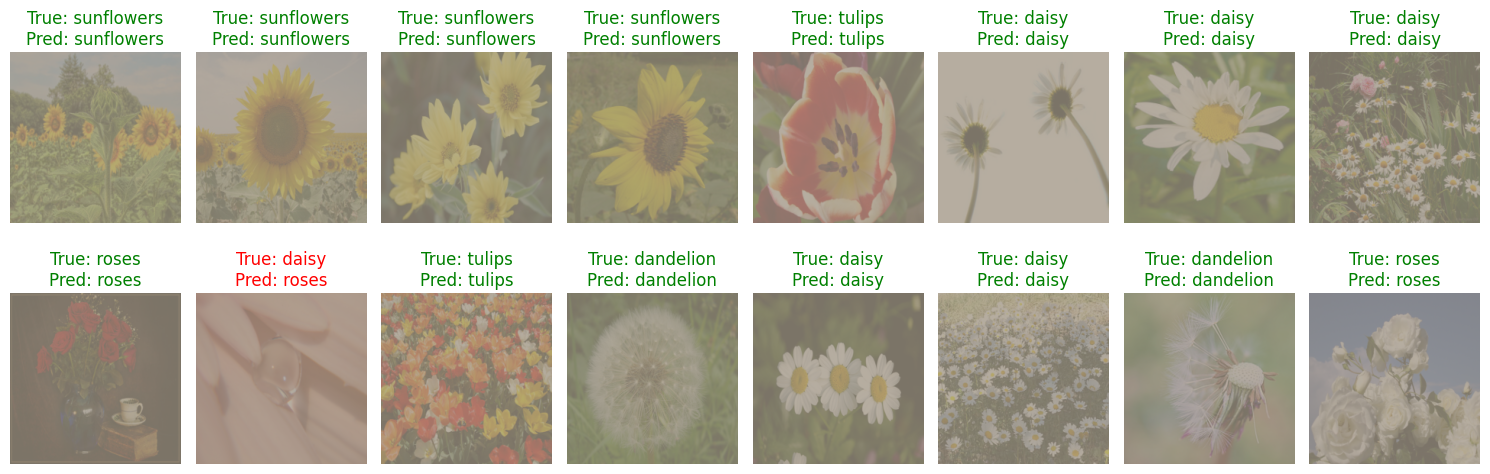

In [71]:
images, labels = next(iter(eval_loader))
images = images.to(device)
labels = labels.to(device)
best_model.eval()
with torch.no_grad():
    outputs = best_model(images)
    _, predicted = torch.max(outputs.data, 1)
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(4, 8, i + 1)
    img = images[i].numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')
    true_label = eval_dataset.classes[labels[i].item()]
    predicted_label = eval_dataset.classes[predicted[i].item()]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()

In [54]:
import json

metadata = {
    "classes": dataset.classes,
    "dropout": dropout
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f)

In [72]:
torch.save({
    "model_state": best_model.state_dict(),
    "classes": dataset.classes,
    "dropout": dropout
}, "flower_checkpoint.pth")

In [50]:
from huggingface_hub import login
login()

In [73]:
from huggingface_hub import HfApi

api = HfApi()

api.upload_file(
    path_or_fileobj="/content/flower_checkpoint.pth",
    path_in_repo="flower_checkpoint.pth",
    repo_id='faranbutt789/flower',
    repo_type="space"
)

flower_checkpoint.pth:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spaces/faranbutt789/flower-vision/commit/3e8937a9c57d56724092cd266563255774a3b3b2', commit_message='Upload flower_checkpoint.pth with huggingface_hub', commit_description='', oid='3e8937a9c57d56724092cd266563255774a3b3b2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/faranbutt789/flower-vision', endpoint='https://huggingface.co', repo_type='space', repo_id='faranbutt789/flower-vision'), pr_revision=None, pr_num=None)